# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [1]:
from google.colab import files
uploaded = files.upload()

Saving transformer_utils.py to transformer_utils.py


In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/mnt/data/cello_suites/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 10
BATCH_SIZE = 32

GENERATE_LEN = 50

## 1. Prepare the Data

In [4]:
# Load the data
file_list = glob.glob("/app/data/bach-cello/*.midi")
print(f"Found {len(file_list)} midi files")

Found 0 midi files


In [5]:
from google.colab import files
uploaded = files.upload()

Saving MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi to MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
Saving MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi to MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi


In [ ]:
parser = music21.converter

In [ ]:
import shutil
import os

target_directory = "/app/data/bach-cello/"
os.makedirs(target_directory, exist_ok=True)  # Create directory if it doesn't exist

for filename in uploaded.keys():
    shutil.move(filename, os.path.join(target_directory, filename))

print(f"Files moved to {target_directory}")

Files moved to /app/data/bach-cello/


In [ ]:
import glob

midi_directory = "/app/data/bach-cello/"  # Replace with your directory path
file_list = glob.glob(midi_directory + "*.midi")

print("Loaded MIDI files:", file_list)

Loaded MIDI files: ['/app/data/bach-cello/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.midi', '/app/data/bach-cello/MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.midi']


In [ ]:


import music21
import glob

midi_directory = "/app/data/bach-cello/"  # Replace with your directory path
file_list = glob.glob(midi_directory + "*.midi")

print("Loaded MIDI files:", file_list)

# Assuming file_list is not empty, load the first MIDI file as an example
if file_list:
    example_score = music21.converter.parse(file_list[0])

    # Display the score in text format
    example_score.show("text")
else:
    print("No MIDI files found in the directory.")

Streaming output truncated to the last 5000 lines.
            {0.75} <music21.chord.Chord E3 B4 C5 G3>
            {1.0} <music21.note.Rest 16th>
            {1.25} <music21.chord.Chord C5 C4>
            {1.5} <music21.note.Rest 16th>
            {1.75} <music21.chord.Chord C4 A5 D3 B5>
            {2.0} <music21.note.Rest 16th>
            {2.25} <music21.chord.Chord F3 C4>
            {2.5} <music21.note.Rest 16th>
            {2.75} <music21.chord.Chord G3 C4 C6>
            {3.0} <music21.chord.Chord C3 E6 E3>
            {3.25} <music21.note.Rest 16th>
            {3.5} <music21.chord.Chord G3 G5 C6>
            {3.75} <music21.chord.Chord A2 C6 F#5 C3>
        {0.0} <music21.stream.Voice 0x7ab2ba28c9a0>
            {0.0} <music21.note.Rest 1/3ql>
            {0.3333} <music21.chord.Chord G3 E5 C4>
            {0.6667} <music21.note.Rest 2/3ql>
            {1.3333} <music21.chord.Chord A5 F3 A3>
            {1.6667} <music21.note.Rest 2/3ql>
            {2.3333} <music21.chord.C

In [ ]:
print("Contents of file_list:", file_list)
print("Number of files in file_list:", len(file_list))

Contents of file_list: ['/app/data/bach-cello/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.midi', '/app/data/bach-cello/MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.midi']
Number of files in file_list: 2


In [ ]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [ ]:
from music21 import environment
print(environment.get('musescoreDirectPNGPath'))

/usr/bin/mscore3


In [ ]:
import os
print(os.path.exists('/Applications/MuseScore 4.app/Contents/MacOS/mscore'))

False


In [ ]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7ab2ac9e3fd0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano '13 to 15: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest half>
    {2.0} <music21.chord.Chord G4 B4>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord C#4 G4 B-4 B4>
    {0.5} <music21.chord.Chord C#4 B-4>
    {1.6667} <music21.chord.Chord C#4 F4 A4 B-4>
    {2.0} <music21.chord.Chord F4 A4>
    {3.3333} <music21.chord.Chord B3 F4 G#4 A4>
    {3.6667} <music21.chord.Chord B3 G#4>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord B3 G#4>
    {0.0833} <music21.chord.Chord G#4>
    {1.3333} <music21.chord.Chord C#4 F4 G4 G#4 B4>
    {1.5833} <music21.chord.Chord C#4 F4 G4 B4>
    {3.0} <music21.chord.Chord G3 C#4 E4 F4 G4 B4>
    {3.3333} <music21.chord.Chord G3 E4 G4 B4>


In [ ]:
import os

# Directory path where parsed data will be stored
parsed_data_path = "/mnt/data/cello_suites/"

# Create the directory if it doesn't exist
os.makedirs(parsed_data_path, exist_ok=True)

print(f"Directory created or exists: {parsed_data_path}")

Directory created or exists: /mnt/data/cello_suites/


In [ ]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /app/data/bach-cello/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.midi


<ipython-input-17-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


10934 notes parsed
2 Parsing /app/data/bach-cello/MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.midi
14157 notes parsed
Building sequences of length 51


In [ ]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 B-5 B-5 B-5 B-5 B-5 E-3 G5 rest E-3 E-3 B-4 B-5 B-5 B-5 G#5 E-3 G5 F5 F5 F4 rest E-5 E-5 F5 F5 A2 rest G5 G5 E-3 rest E-2 rest C#2 G#5 G#5 G#5 G#5 G#2 F3 rest C#2 F5 F5 G#5 G#5 rest F#5 F#5 F#4 F5 ...

Duration string
 0.25 1/12 1/6 1/6 1/3 1/3 1/3 1/12 0.25 1/3 1/6 1/12 5/12 1/6 1/12 0.25 0.25 0.25 1/12 1/6 0.25 0.25 0.25 1/6 1/6 1/6 1/6 1/3 1/6 1/12 0.25 1/3 0.5 1/3 1/3 0.25 1/12 1/12 1/12 0.25 0.25 1/3 1/3 1/3 1/6 1/12 0.25 1/6 1/6 1/6 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [ ]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        27         2
        27         3
        27         5
        27         5
        27         4
        31         4
         7         4
         2         3
        31         2
        31         4
         8         5


In [ ]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 77
0: 
1: [UNK]
2: rest
3: E-5
4: G#4
5: G4
6: C5
7: G5
8: B-4
9: C#5

DURATIONS_VOCAB: length = 45
0: 
1: [UNK]
2: 0.25
3: 1/12
4: 1/3
5: 1/6
6: 0.5
7: 0.75
8: 5/12
9: 2/3


## 3. Create the Training Set <a name="create"></a>

In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [ ]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(32, 50), dtype=int64, numpy=
array([[ 6, 45,  7, ..., 28, 42, 26],
       [45,  7,  7, ..., 42, 26, 22],
       [ 7,  7, 38, ..., 26, 22, 31],
       ...,
       [57, 57, 58, ..., 28, 14, 22],
       [57, 58, 58, ..., 14, 22,  5],
       [58, 58, 57, ..., 22,  5, 24]])>, <tf.Tensor: shape=(32, 50), dtype=int64, numpy=
array([[4, 3, 4, ..., 2, 4, 4],
       [3, 4, 4, ..., 4, 4, 3],
       [4, 4, 6, ..., 4, 3, 2],
       ...,
       [2, 2, 2, ..., 2, 6, 2],
       [2, 2, 5, ..., 6, 2, 2],
       [2, 5, 3, ..., 2, 2, 6]])>), (<tf.Tensor: shape=(32, 50), dtype=int64, numpy=
array([[45,  7,  7, ..., 42, 26, 22],
       [ 7,  7, 38, ..., 26, 22, 31],
       [ 7, 38,  7, ..., 22, 31, 37],
       ...,
       [57, 58, 58, ..., 14, 22,  5],
       [58, 58, 57, ..., 22,  5, 24],
       [58, 57, 41, ...,  5, 24,  4]])>, <tf.Tensor: shape=(32, 50), dtype=int64, numpy=
array([[3, 4, 4, ..., 4, 4, 3],
       [4, 4, 6, ..., 4, 3, 2],
       [4, 6, 5, ..., 3, 2, 2],
       ...,
   

## 5. Create the causal attention mask function <a name="causal"></a>

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

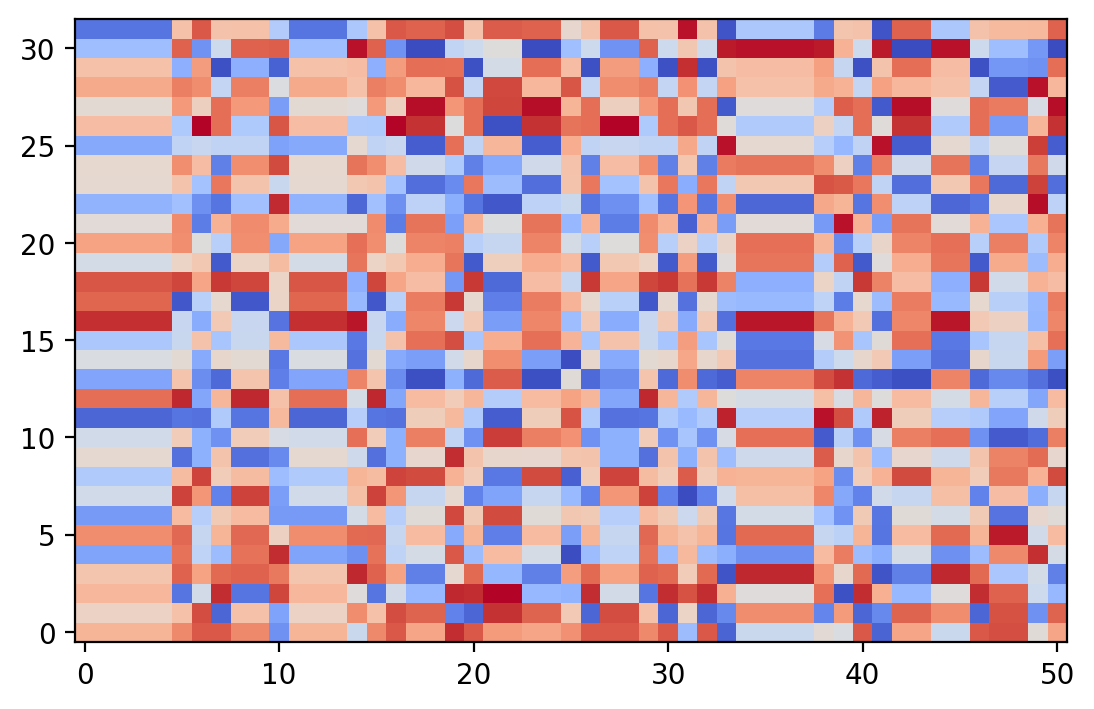

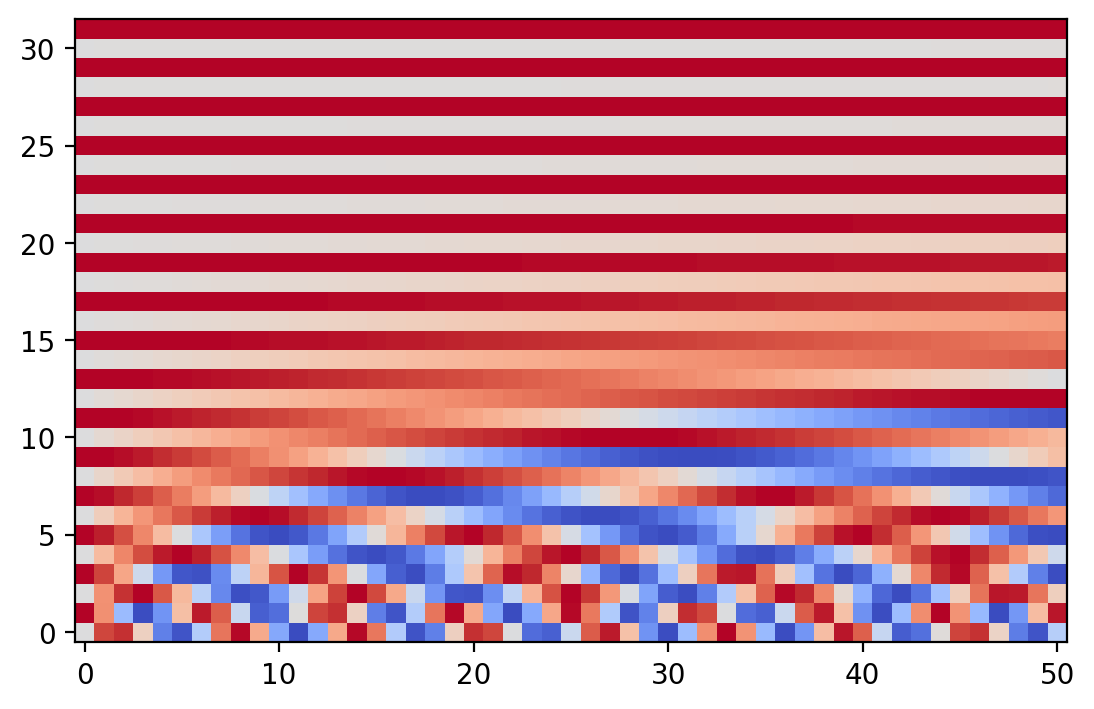

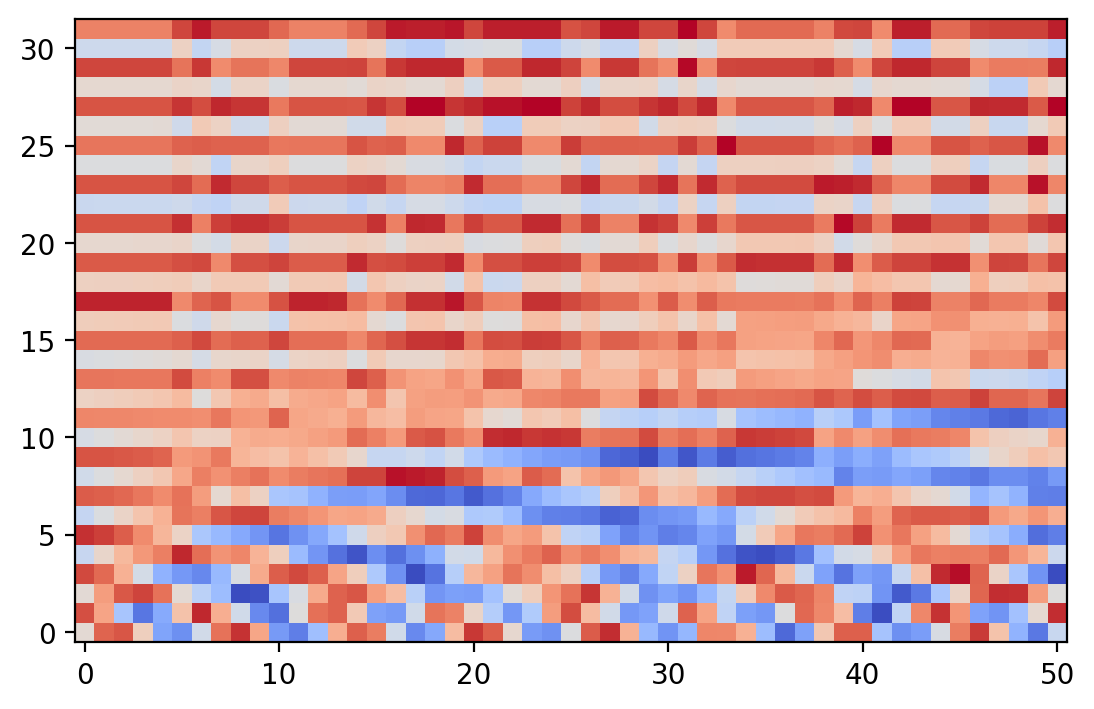

In [ ]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          9,856 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          5,760 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 77)       │         19,789 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 45)       │         11,565 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,494,394 (5.70 MB)

 Trainable params: 1,494,394 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/app/notebooks/11_music/01_transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [ ]:
from keras import callbacks

# Create a model save checkpoint with the correct filepath
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",  # Correct extension
    save_weights_only=True,
    save_freq="epoch",
    monitor="val_loss",  # Or the metric you want to monitor
    save_best_only=True,  # Save only the best model weights
    verbose=1
)

In [ ]:
from keras import callbacks
import os

# Ensure the checkpoint directory exists
os.makedirs("./checkpoint", exist_ok=True)

# Create a model save checkpoint with the correct .keras extension
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",  # Correct extension
    save_weights_only=False,  # Save the full model
    save_freq="epoch",  # Save at the end of every epoch
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    verbose=1
)

In [ ]:
from keras import callbacks
import os

# Ensure the checkpoint directory exists
os.makedirs("./checkpoint", exist_ok=True)

# Create a model save checkpoint with the correct file extension
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",  # Correct extension for saving weights
    save_weights_only=True,
    save_freq="epoch",  # Save at the end of each epoch
    verbose=0
)

# TensorBoard callback for logging
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
!sudo apt update
!sudo apt install musescore

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,620 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,224 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/ma

In [ ]:
from music21 import environment
environment.set ('musescoreDirectPNGPath', '/usr/bin/mscore')

In [ ]:
from keras import callbacks
import os

# Ensure the checkpoint directory exists
os.makedirs("./checkpoint", exist_ok=True)

# Create a model save checkpoint with the correct .keras extension
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",  # Correct extension
    save_weights_only=False,  # Save the full model
    save_freq="epoch",  # Save at the end of every epoch
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    verbose=1
)

# ... (Rest of your code)

class MusicGenerator(callbacks.Callback):
    # ... (Your existing code)

    def on_epoch_end(self, epoch, logs):
        # ... (Your existing code)

        # Create the output directory if it doesn't exist
        os.makedirs(os.path.dirname("/app/notebooks/11_music/01_transformer/output/output-0000.mid"), exist_ok=True)

        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/app/notebooks/11_music/01_transformer/output",
                f"output-{epoch:04d}.mid",
            ),
        )

In [ ]:
output_dir = "/app/notebooks/11_music/01_transformer/output"  # Define the output directory path
os.makedirs(output_dir, exist_ok=True)
print(f"Directory created or already exists: {output_dir}")

Directory created or already exists: /app/notebooks/11_music/01_transformer/output


In [ ]:
# Save the final model
# Save the model in HDF5 format
model.save("./models/model.h5")

# 3. Generate music using the Transformer

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


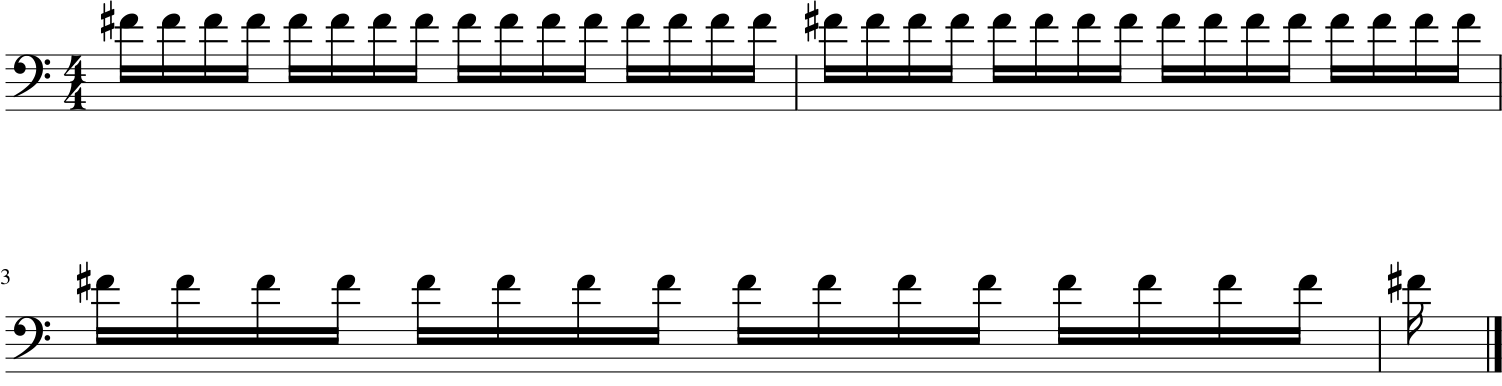

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/app/notebooks/11_music/01_transformer/output",
        "output-" + timestr + ".mid",
    ),
)

## Note probabilities

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

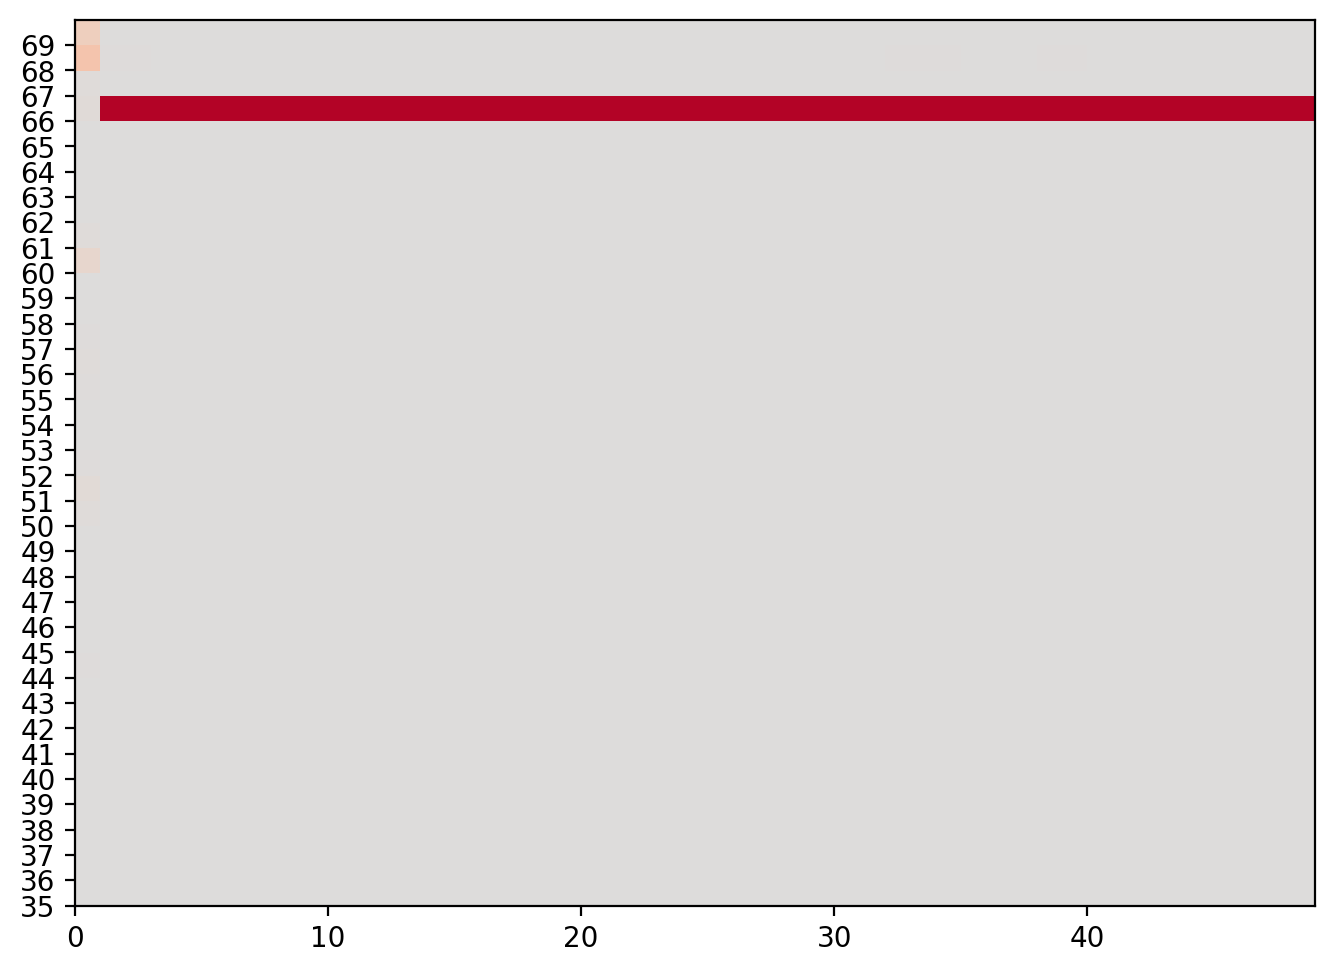

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

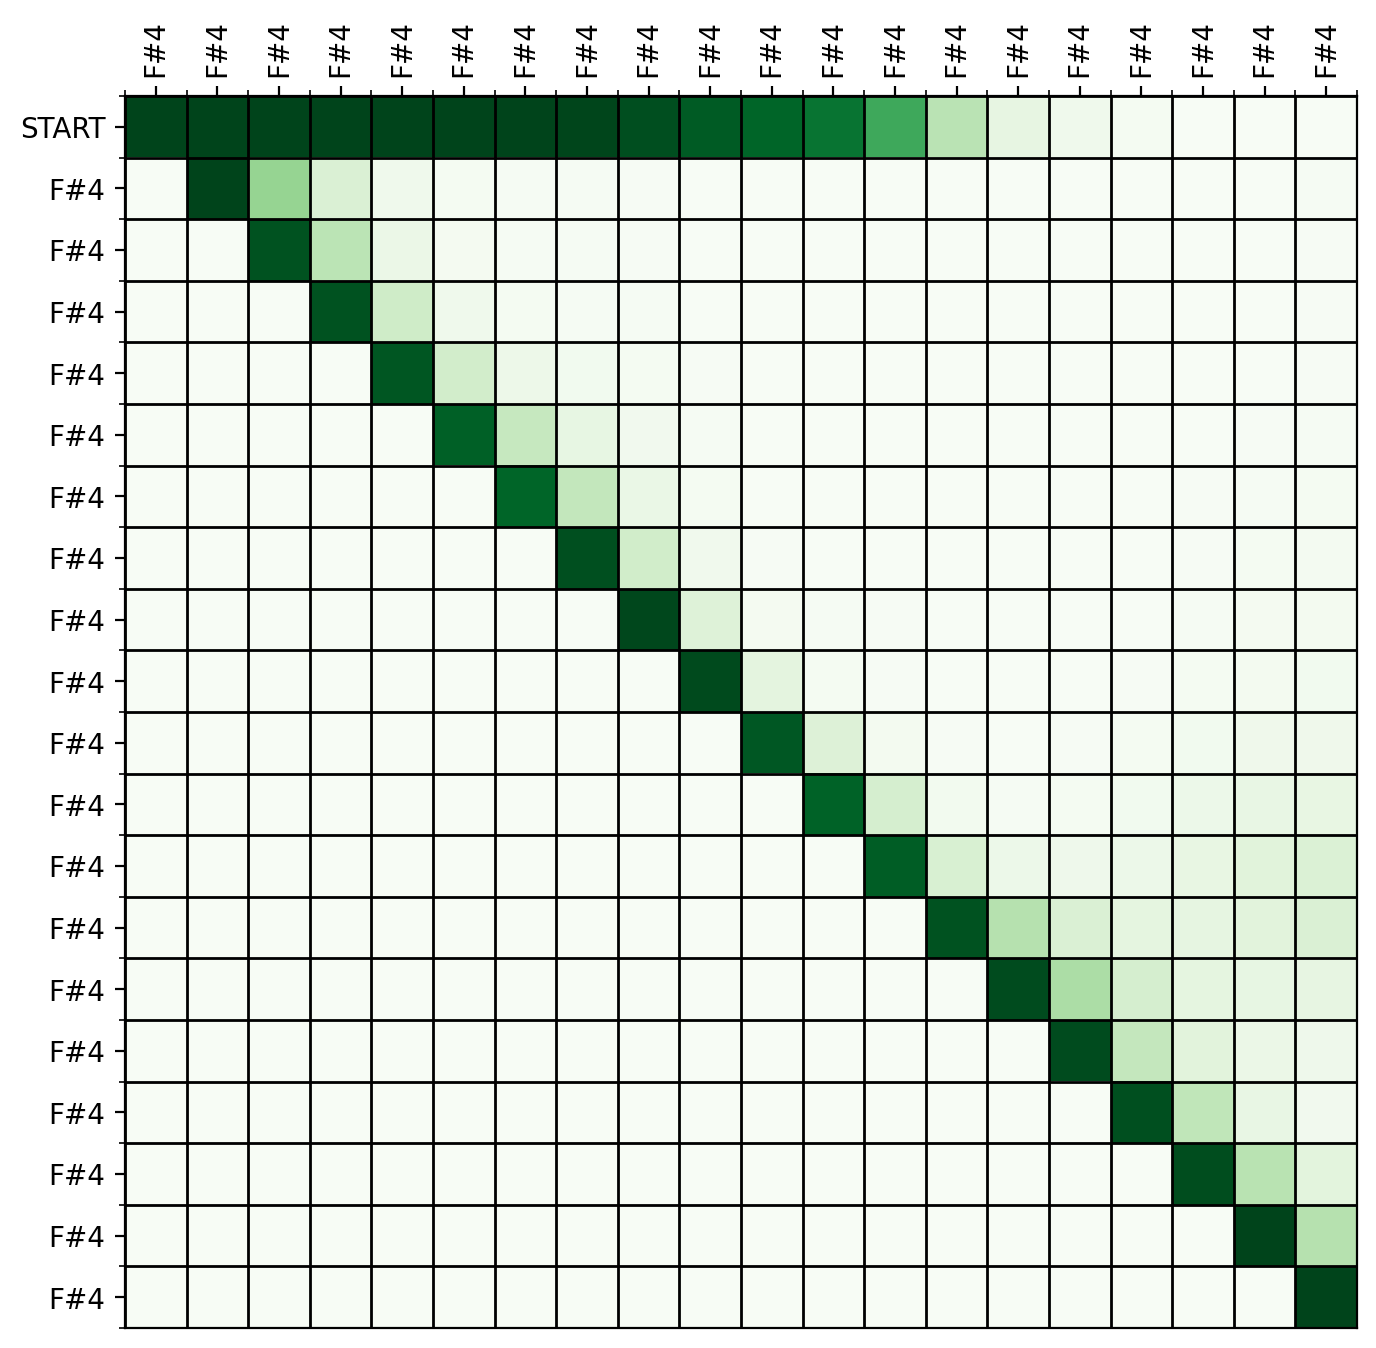

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()